In [1]:
!pip install "sb3_contrib>=2.0.0a1" --upgrade
!pip install "stable_baselines3>=2.0.0a1" --upgrade
!pip install pvlib

## Please following the instructions and **DO NOT** modify the example file in the shared drive! Download the folder "BEAR" and upload it to **your Drive** in "My Drive", then run the cells

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
cwd = os.getcwd()

os.chdir("gdrive/My Drive")

ModuleNotFoundError: No module named 'google.colab'

In [1]:
from BEAR.Env.env_building  import BuildingEnvReal
from BEAR.Controller.MPC_Controller import MPCAgent
from BEAR.Utils.utils_building import ParameterGenerator,get_user_input
import numpy as np
import functools
import datetime
import os
import time
from collections import deque
import matplotlib.pyplot as plt

##Test

We start by creating an environment with a OfficeSmall type building at Tucson, and setting the weather type as Hot Dry:

In [2]:
env = get_user_input()
numofhours=24
#Initialize
env.reset()
for i in range(numofhours):
    a = env.action_space.sample()#Randomly select an action
    obs, r, terminated, truncated, _ = env.step(a)#Return observation and reward
RandomController_state=env.statelist #Collect the state list
RandomController_action=env.actionlist #Collect the action list
env._get_info()

Invalid climate zone. Please try again.
###############All Zones from Ground############
CORE_BOTTOM  [Zone index]:  0
PERIMETER_BOT_ZN_3  [Zone index]:  1
PERIMETER_BOT_ZN_2  [Zone index]:  2
PERIMETER_BOT_ZN_1  [Zone index]:  3
PERIMETER_BOT_ZN_4  [Zone index]:  4
FIRSTFLOOR_PLENUM  [Zone index]:  5
CORE_MID  [Zone index]:  6
PERIMETER_MID_ZN_3  [Zone index]:  7
PERIMETER_MID_ZN_2  [Zone index]:  8
PERIMETER_MID_ZN_1  [Zone index]:  9
PERIMETER_MID_ZN_4  [Zone index]:  10
MIDFLOOR_PLENUM  [Zone index]:  11
CORE_TOP  [Zone index]:  12
PERIMETER_TOP_ZN_3  [Zone index]:  13
PERIMETER_TOP_ZN_2  [Zone index]:  14
PERIMETER_TOP_ZN_1  [Zone index]:  15
PERIMETER_TOP_ZN_4  [Zone index]:  16
TOPFLOOR_PLENUM  [Zone index]:  17
###################################################
How would you like to modify the reward function?
Enter 1 to use the default reward function.
Enter 2 to customize weights of the default function.
Enter 3 to fully customize the reward function.
1. Default reward funct

{'zone_temperature': array([-0.17270407,  2.02566049, -5.0463131 ,  1.72991143, -5.28779306,
         0.34296693,  2.62886983,  4.62869054,  0.92151095,  4.70462926,
         2.28664697,  3.05245279,  5.37318694,  5.28270216,  3.27225615,
         7.35053815,  4.05512075,  5.73774522]),
 'reward_breakdown': {'comfort_level': -1960.2683909310483,
  'power_consumption': -1.4472353610992432}}

In [5]:
RandomController_action[0]

array([-1343.7982,  1964.0427, -3777.8914, -7113.3667, -6875.5864,
       -3613.5183,  6615.708 , -2597.1848, -6115.7935, -3519.7388,
        2510.2476,  4863.8364,  6918.0894,  1489.8923, -7871.1196,
       -7881.934 ,  5062.732 ,  6804.7686], dtype=float32)

With the new version updated, users can also customize the reward function now. A custom reward function is a function you define that takes the current state, the action, and the error (difference between target and actual temperature), and the new state as inputs, and returns a reward value. This reward value is used to guide the agent's learning.The function should be written on **reward_functions.py** in the folder **BEAR/Customize**. A sample reward function is shown here:


In [22]:
def my_custom_reward_function(self, state, action, error, state_new):
    # This is your default reward function
    # Initialize the reward
    reward = 0
    self.co2_rate=0.01
    self.temp_rate=0.01

    # Desired temperature range
    lower_temp = 18
    upper_temp = 22

    # Calculate the contribution of action to the reward
    action_contribution = LA.norm(action, 2) * self.q_rate
    reward -= action_contribution

    # Calculate the contribution of error to the reward
    error_contribution = LA.norm(error, 2) * self.error_rate
    reward -= error_contribution

    # Calculate the contribution of temperature deviation to the reward
    temp_deviation = np.sum(np.maximum(0, state_new - upper_temp) + np.maximum(0, lower_temp - state_new)) * self.temp_rate
    reward -= temp_deviation

    # Calculate the contribution of CO2 emissions to the reward
    co2_emission = LA.norm(action, 2) * self.co2_rate
    reward -= co2_emission

    self._reward_breakdown['action_contribution'] -= action_contribution
    self._reward_breakdown['error_contribution'] -= error_contribution
    self._reward_breakdown['temp_deviation'] -= temp_deviation
    self._reward_breakdown['co2_emission'] -= co2_emission
    return reward

For more advance users, you can directly modify the ParameterGenerator and BuildingEnvReal to customize your enviornment:

In [6]:
Parameter=ParameterGenerator('OfficeSmall','Hot_Dry','Tucson')  #Description of ParameterGenerator in bldg_utils.py
#Create environment
env = BuildingEnvReal(Parameter)
numofhours=24
#Initialize with user-defined indoor temperature
env.reset(options={'T_initial':np.array([18.24489859, 18.58710076, 18.47719682, 19.11476084, 19.59438163,15.39221207])})
for i in range(numofhours):
    a = env.action_space.sample()#Randomly select an action
    obs, r, terminated, truncated, _ = env.step(a)#Return observation and reward
RandomController_state=env.statelist #Collect the state list
RandomController_action=env.actionlist #Collect the action list
env._get_info()

###############All Zones from Ground############
CORE_ZN  [Zone index]:  0
PERIMETER_ZN_1  [Zone index]:  1
PERIMETER_ZN_2  [Zone index]:  2
PERIMETER_ZN_3  [Zone index]:  3
PERIMETER_ZN_4  [Zone index]:  4
ATTIC  [Zone index]:  5
###################################################


{'zone_temperature': array([11.50499167, 12.40483428, 21.07799206, 18.43007991, 15.58897709,
        18.00433628]),
 'reward_breakdown': {'comfort_level': -875.9832537353334,
  'power_consumption': -0.8153920183181761}}

The state space:$$s_k=[T_1[k],T_2[k], ...,T_{M}[k],Q_p[k],T_G[k],T_{E}[k],Q_{ghi}[k]]$$

The action space:$$a_k=[Q^z_{1}[k],Q^z_{2}[k],...,Q^z_{M}[k]]$$

In [24]:
obs_dim = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(obs_dim))
action_dim = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(action_dim))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))
print('Sample State :', RandomController_state[0])
print('Sample Action :', RandomController_action[0])

Size of State Space ->  20
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0
Sample State : [18.24489859 18.58710076 18.47719682 19.11476084 19.59438163 15.39221207
  5.6         0.          0.          0.          0.          0.
  0.         20.9        -0.03714446 -0.03714446 -0.03714446 -0.03714446
 -0.03714446 -0.03714446]
Sample Action : [-5590.592   6761.589   1757.7975  3065.9058 -1750.4368 -2015.4384]


###No Action

We first test the environment with no actions. Let's loop for 24 hours and plot the temperature and energy comsumption of each zones :

In [7]:
obs

array([11.50499167, 12.40483428, 21.07799206, 18.43007991, 15.58897709,
       18.00433628,  4.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 20.9       , -0.03335059,
       -0.03335059, -0.03335059, -0.03335059, -0.03335059, -0.03335059])

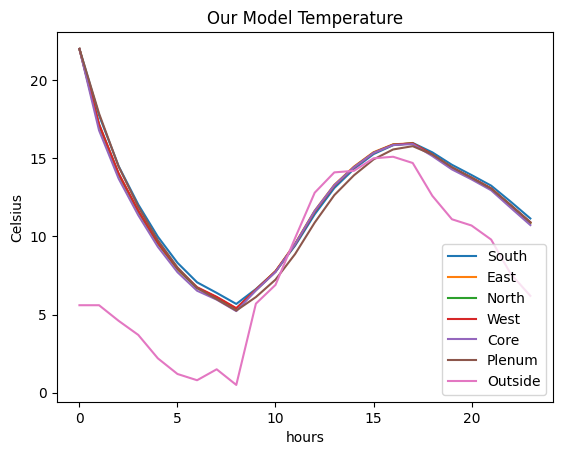

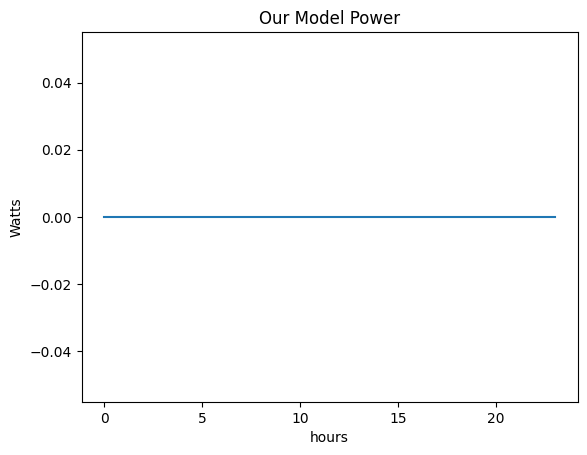

In [8]:

numofhours=24
env.reset()
a=env.action_space.sample()
for i in range(numofhours):

    a = [0,0,0,0,0,0]
    obs, r, terminated, truncated, _ = env.step(a)
plt.plot(np.array(env.statelist)[:,:7])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')

plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))

plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()

In [9]:
print('zone temerature at 1 a.m. :', np.array(env.statelist)[1,:6])

zone temerature at 1 a.m. : [17.75179317 17.07085633 17.14668666 17.19433022 16.78964807 17.86825243]


###MPC

Then we use a MPC controller and set each room at 22 degrees:

total reward is:  -0.19466647171182835


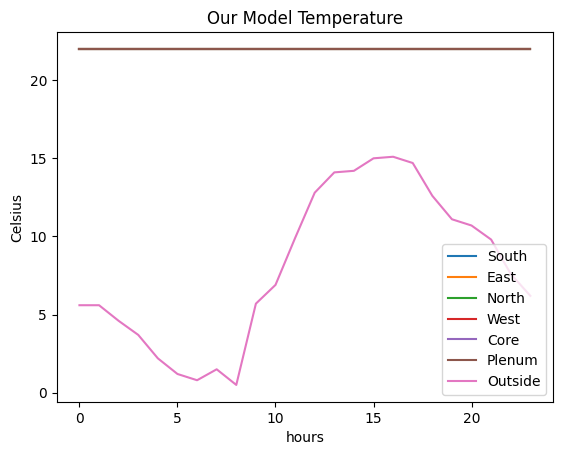

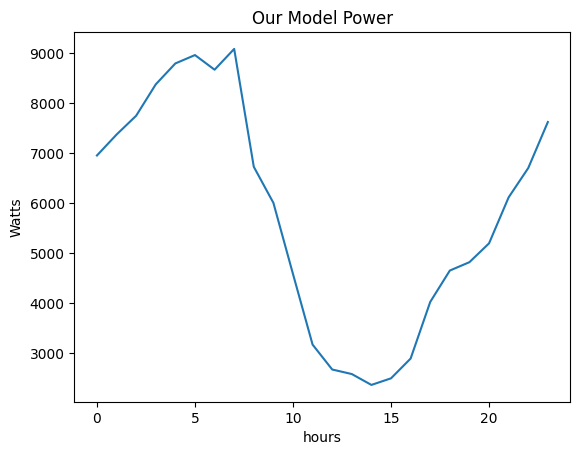

In [10]:
agent = MPCAgent(env,
                gamma=env.gamma,
                safety_margin=0.96, planning_steps=10)
env.reset()
numofhours=24
reward_total=0
for i in range(numofhours):
    a,s = agent.predict(env)
    obs, r, terminated, truncated, _ = env.step(a)
    reward_total+=r
print('total reward is: ',reward_total)
plt.plot(np.array(env.statelist)[:,:7])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()
MPCstate=env.statelist
MPCaction=env.actionlist

In [31]:
print('zone temerature:', np.array(env.statelist)[0,:6])

zone temerature: [22. 22. 22. 22. 22. 22.]


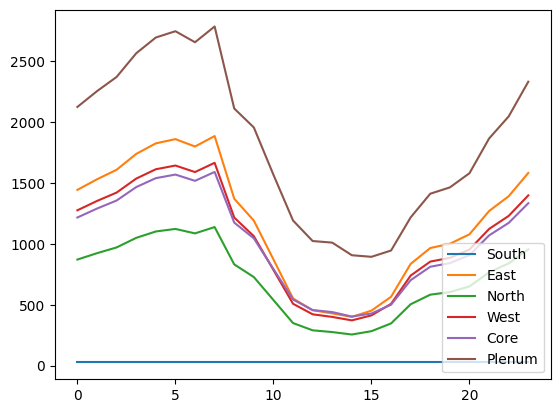

In [12]:
plt.plot(np.array(env.actionlist))
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
#plt.ylim([0,50])
plt.show()

### Reinforcement Learning

Finally, we use a PPO controller to demonstrate RL usage. We perform a quick train with default settings and save the model:

In [13]:
from stable_baselines3 import PPO ,DQN,DDPG
from stable_baselines3.common.logger import configure
from stable_baselines3.ppo import MlpPolicy
# from stable_baselines.bench import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_vec_env

In [21]:
import torch
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [14]:
seed=0
env.reset()
set_random_seed(seed=seed)
model = PPO(MlpPolicy, env, verbose=1)
rewardlist=[]
action_record=[]

for i in range(100):
  model.learn(total_timesteps=1000)
  rw=0
  vec_env = model.get_env()
  obs = vec_env.reset()
  for i in range(24):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    rw+=rewards
  print(rw/24)
  rewardlist.append(rw/24)
  action_record.append(np.array(env.actionlist).sum(axis=1))
print("################TRAINING is Done############")
model.save("PPO_quick")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 334  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
[-33.111595]
-----------------------------
| time/              |      |
|    fps             | 793  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
[-22.463072]
-----------------------------
| time/              |      |
|    fps             | 763  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
[-30.207443]
-----------------------------
| time/              |      |
|    fps             | 810  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
[-25.941156]
-------------

Then, we load the model and see the performance of the state and action:

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial observation [[22.         22.         22.         22.         22.         22.
   5.6         0.          0.          0.          0.          0.
   0.         20.9        -0.07856952 -0.07856952 -0.07856952 -0.07856952
  -0.07856952 -0.07856952]]


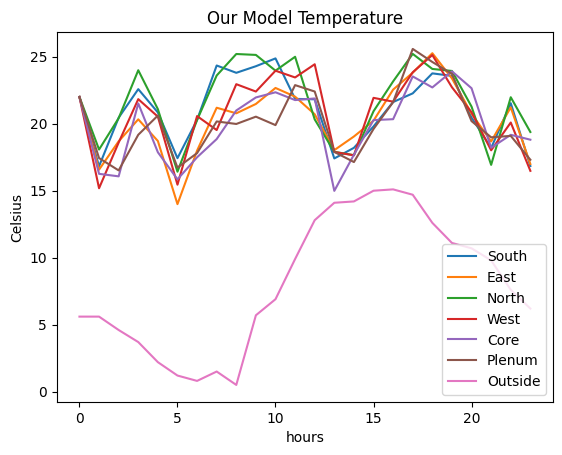

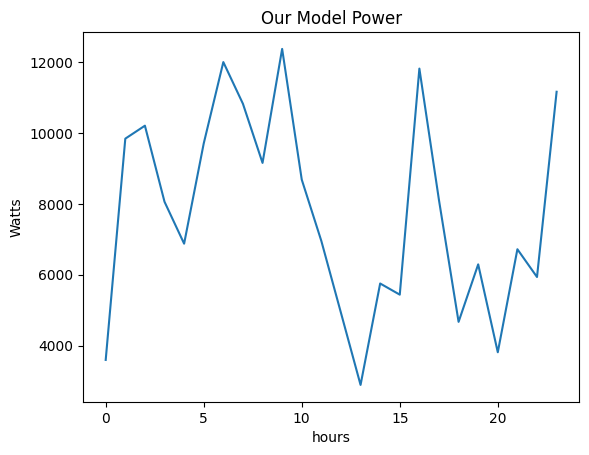

In [22]:

model = PPO(MlpPolicy, env, verbose=1)
vec_env = model.get_env()
model = PPO.load("PPO_quick")
obs = vec_env.reset()
print("Initial observation", obs)

for i in range(24):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
plt.plot(np.array(env.statelist)[:,:7])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()

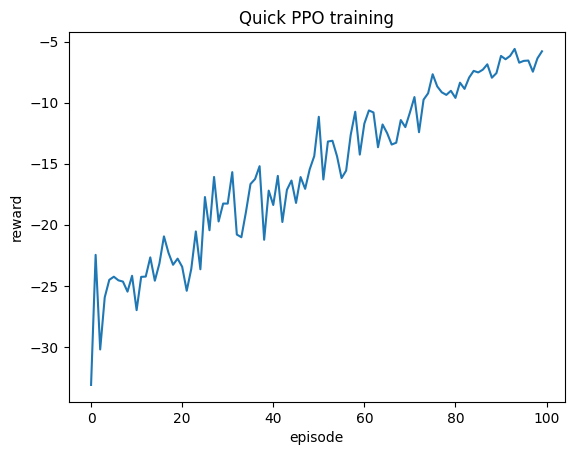

In [23]:
plt.title('Quick PPO training')
plt.plot(rewardlist)
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

In [ ]:
env.close()